In [1]:
# Recommender Systems - Suggest similar items based on user's profile and
# search or views.

# 2 Types of Systems 
# 1) Collaborative Filtering - Recommends items based on similarity 
# measures between users or items. The basic assumption is users with
# similar interest have common preferences. 
# Collaborative Filtering uses a user-item matrix to generate recommendations
# The matrix contains values that indicates users preference towards a
# given item. User preference values can be both
# a) Explicit feedback - Users Ratings, Scores, stars,etc.
# b) Implicit feedback - Indirect user behaviour like number of times
# watched, purchased, or usage.

# 2) Content Based Recommendation System - In this system overview or 
# story or written feedback is collected and using Natural Language 
# Processing process the content convert into TFIDF matrix. After which
# Similarity is calculated using distance metrics like Cosine, Euclidean,etc
# to find similar items.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
moviedf=pd.read_csv("movies_metadata.csv",low_memory=False)

In [5]:
moviedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [6]:
# Collaborative Filtering - IMDB Simple Recommender formula

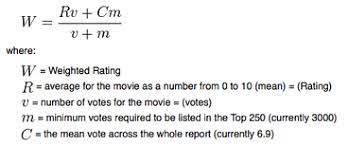

In [7]:
moviedf.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [11]:
C=moviedf.vote_average.mean()
C

5.618207215134185

In [18]:
m=moviedf.vote_count.quantile(0.90)
m

160.0

In [23]:
top_movies=moviedf.copy().loc[moviedf.vote_count>=m]

In [24]:
top_movies.shape

(4555, 24)

In [25]:
def weighted_rating(x,m=m,C=C):
    v=x['vote_count']
    R=x['vote_average']
    return (v/(v+m)*R)+(m/(m+v)*C)

In [26]:
top_movies['weighted_rating']=top_movies.apply(weighted_rating,axis=1)

In [28]:
top_movies=top_movies.sort_values('weighted_rating',ascending=False)

In [41]:
top_movies[['title','weighted_rating']].head(10)

,title,weighted_rating
314,The Shawshank Redemption,8.445869
834,The Godfather,8.425439
10309,Dilwale Dulhania Le Jayenge,8.421453
12481,The Dark Knight,8.265477
2843,Fight Club,8.256385
292,Pulp Fiction,8.251406
522,Schindler's List,8.206639
23673,Whiplash,8.205404
5481,Spirited Away,8.196055
2211,Life Is Beautiful,8.187171


In [42]:
# Content Based Recommender Systems
moviedf.overview.head()

0    Led by Woody, Andy's toys live happily in his ...
1    When siblings Judy and Peter discover an encha...
2    A family wedding reignites the ancient feud be...
3    Cheated on, mistreated and stepped on, the wom...
4    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [44]:
tfidf=TfidfVectorizer(stop_words="english")

In [46]:
moviedf.overview=moviedf.overview.fillna('')

In [47]:
tfidf_matrix=tfidf.fit_transform(moviedf.overview)

In [48]:
tfidf_matrix.shape

(45466, 75827)

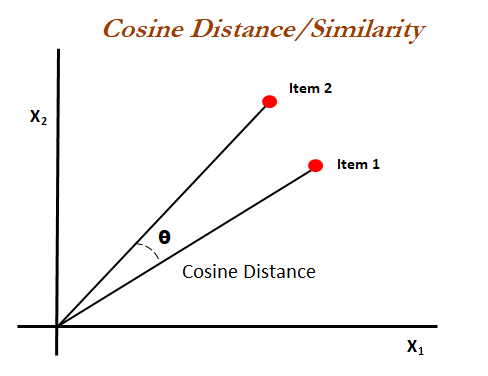
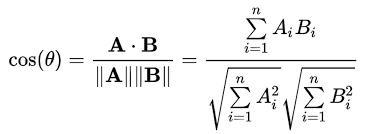

In [49]:
from sklearn.metrics.pairwise import linear_kernel

In [50]:
cosine_sim=linear_kernel(tfidf_matrix,tfidf_matrix)

In [58]:
cosine_sim.shape

(45466, 45466)

In [51]:
indices=pd.Series(moviedf.index,index=moviedf.title).drop_duplicates()

In [52]:
def get_recommend(title,cosine_sim=cosine_sim):
    idx=indices[title]
    sim_scores=list(enumerate(cosine_sim[idx]))
    sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=False)
    sim_scores=sim_scores[1:11]
    movie_indices=[i[0] for i in sim_scores]
    return moviedf.title.iloc[movie_indices]

In [56]:
get_recommend('Jumanji')

4        Father of the Bride Part II
6                            Sabrina
7                       Tom and Huck
9                          GoldenEye
11       Dracula: Dead and Loving It
12                             Balto
14                  Cutthroat Island
15                            Casino
16             Sense and Sensibility
18    Ace Ventura: When Nature Calls
Name: title, dtype: object

In [61]:
from surprise import NormalPredictor,Dataset,Reader,SVD
from surprise.model_selection import cross_validate

In [68]:
data=Dataset.load_builtin('ml-100k')

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /Users/rajeshprabhakarkaila/.surprise_data/ml-100k


In [69]:
algo=SVD()

In [70]:
cross_validate(algo,data,measures=['RMSE','MAE'],cv=5,verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9371  0.9363  0.9355  0.9340  0.9385  0.9363  0.0015  
MAE (testset)     0.7384  0.7368  0.7386  0.7373  0.7405  0.7383  0.0013  
Fit time          0.29    0.29    0.29    0.29    0.29    0.29    0.00    
Test time         0.04    0.04    0.04    0.04    0.04    0.04    0.00    


{'test_rmse': array([0.93705939, 0.93629665, 0.93547506, 0.9340423 , 0.93847144]),
 'test_mae': array([0.73842577, 0.73682571, 0.73861398, 0.7373434 , 0.74047384]),
 'fit_time': (0.2898712158203125,
  0.29291391372680664,
  0.2890148162841797,
  0.2926297187805176,
  0.29339098930358887),
 'test_time': (0.03920888900756836,
  0.03958606719970703,
  0.03949093818664551,
  0.03913998603820801,
  0.03932523727416992)}